In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [ ]:
!unzip drive/MyDrive/3features.zip


Streaming output truncated to the last 5000 lines.
  inflating: 3features/test/other/20180612_FIRE_rm-w-mobo-c_1528842726_+01740_sbb_horizon_6_flipped.jpg  
  inflating: 3features/test/other/20190924_FIRE_bl-s-mobo-c_1569363173_+01080_sbb_horizon_3.jpg  
  inflating: 3features/test/other/20190924_FIRE_wc-e-mobo-c_1569362781_+00421_sbb_horizon_2_rotated.jpg  
  inflating: 3features/test/other/20190728_Dehesa_lp-n-mobo_1564363801_+01980_sbb_horizon_1.jpg  
  inflating: 3features/test/other/20191006_FIRE_pi-s-mobo-c_1570388167_+02398_sbb_horizon_2_rotated.jpg  
  inflating: 3features/test/other/20170627_FIRE_lp-n-iqeye_1498581912_+00480_sbb_horizon_2_rotated.jpg  
  inflating: 3features/test/other/20190728_Dehesa_lp-n-mobo_1564363801_+01980_sbb_horizon_6.jpg  
  inflating: 3features/test/other/20170627_FIRE_lp-n-iqeye_1498581912_+00480_sbb_horizon_3_flipped.jpg  
  inflating: 3features/test/other/20191006_FIRE_pi-s-mobo-c_1570388167_+02398_sbb_horizon_3_flipped.jpg  
  inflating: 3feature

In [ ]:
!unzip drive/MyDrive/modeldata.zip > /dev/null


In [ ]:
data_dir = '3features/'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally.
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))

print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 14318 images under train
Loaded 3671 images under val
Loaded 1843 images under test
Classes: 
['cloud', 'other', 'smoke']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


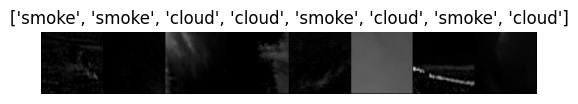

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [ ]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training

    # Set model for evaluation
    vgg.train(False)
    vgg.eval()

    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]


        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)

        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()

        images_so_far += size
        if images_so_far >= num_images:
            break

    vgg.train(mode=was_training) # Revert model back to original training state

In [ ]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0

    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)

    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()

    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]

    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [ ]:
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load("modeldata" + "/vgg16_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000

resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)


1000


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 72.8MB/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python

In [ ]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

for param in resnet18.parameters():
    param.require_grad = False

for param in resnet34.parameters():
    param.require_grad = False

for param in resnet50.parameters():
    param.require_grad = False




In [ ]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier



num_features = resnet18.fc.in_features     #extract fc layers features
resnet18.fc = nn.Linear(num_features, 3) #(num_of_class == 2)

num_features = resnet34.fc.in_features     #extract fc layers features
resnet34.fc = nn.Linear(num_features, 3) #(num_of_class == 2)

num_features = resnet50.fc.in_features     #extract fc layers features
resnet50.fc = nn.Linear(num_features, 3) #(num_of_class == 2)






In [ ]:
resume_training = True

if resume_training:
    print("Loading pretrained models..")
    vgg16.load_state_dict(torch.load('/content/3features/vgg16.pt'))
    resnet18.load_state_dict(torch.load('/content/3features/resnet18model.pt'))
    resnet34.load_state_dict(torch.load('/content/3features/resnet34model.pt'))
    resnet50.load_state_dict(torch.load('/content/3features/resnet50model.pt'))
    print("Loaded!")

Loading pretrained models..
Loaded!


In [ ]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    resnet18.cuda()
    resnet34.cuda()
    resnet50.cuda()

criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# optimizer_ft = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# optimizer_ft = optim.SGD(resnet34.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [ ]:
print("Test before training")
eval_model(resnet18, criterion)

Test before training
Evaluating model
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test batch 0/107

<ipython-input-6-82b6eb92a94e>:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Test batch 100/107
Evaluation completed in 0m 12s
Avg loss (test): 0.1505
Avg acc (test): 0.2080
----------


<ipython-input-5-8ec5502ca051>:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Ground truth:


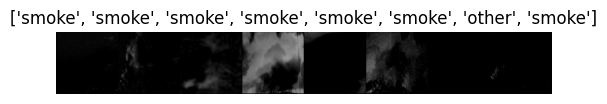

Prediction:


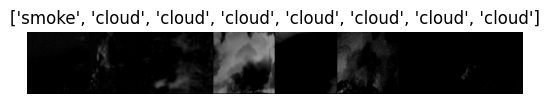

In [ ]:
visualize_model(resnet18)

In [ ]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0

    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0

    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)

        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0

        vgg.train(True)

        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)

            # Use half training dataset
            if i >= train_batches / 2:
                break

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            loss_train += loss.data.item()
            acc_train += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]

        vgg.train(False)
        vgg.eval()

        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_val += loss.data.item()
            acc_val += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]

        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()

        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())

    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))

    vgg.load_state_dict(best_model_wts)
    return vgg

In [ ]:
# vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)
# torch.save(vgg16.state_dict(), '3features/vgg16.pt')


# torch.sve(resnet50.state_dict(), 'invert/resnet50model.pt')

# resnet34 = train_model(resnet34, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=7)
# torch.save(resnet34.state_dict(), 'difference/resnet34.pt')

# resnet18 = train_model(resnet18, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=7)
# torch.save(resnet18.state_dict(), 'difference/resnet18.pt')

resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=7)
torch.save(resnet50.state_dict(), 'difference/resnet50.pt')


Epoch 0/7
----------
Training batch 200/216.5
Validation batch 0/116

<ipython-input-15-e91e35471cd3>:71: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Validation batch 100/116
Epoch 0 result: 
Avg loss (train): 0.0492
Avg acc (train): 0.8488
Avg loss (val): 0.0396
Avg acc (val): 0.8864
----------

Epoch 1/7
----------
Training batch 200/216.5
Validation batch 100/116
Epoch 1 result: 
Avg loss (train): 0.0490
Avg acc (train): 0.8789
Avg loss (val): 0.0293
Avg acc (val): 0.9199
----------

Epoch 2/7
----------
Training batch 200/216.5
Validation batch 100/116
Epoch 2 result: 
Avg loss (train): 0.0354
Avg acc (train): 0.9159
Avg loss (val): 0.0274
Avg acc (val): 0.9275
----------

Epoch 3/7
----------
Training batch 200/216.5
Validation batch 100/116
Epoch 3 result: 
Avg loss (train): 0.0352
Avg acc (train): 0.9159
Avg loss (val): 0.0254
Avg acc (val): 0.9361
----------

Epoch 4/7
----------
Training batch 200/216.5
Validation batch 100/116
Epoch 4 result: 
Avg loss (train): 0.0310
Avg acc (train): 0.9188
Avg loss (val): 0.0142
Avg acc (val): 0.9665
----------

Epoch 5/7
----------
Training batch 200/216.5
Validation batch 100/116
Epoch

In [ ]:
eval_model(resnet18, criterion)


Evaluating model
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test batch 0/107

<ipython-input-6-82b6eb92a94e>:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Test batch 100/107
Evaluation completed in 0m 6s
Avg loss (test): 0.0421
Avg acc (test): 0.8801
----------


<ipython-input-5-8ec5502ca051>:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Ground truth:


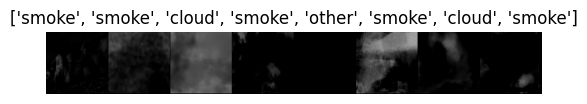

Prediction:


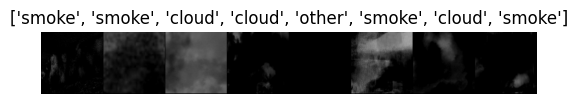

Ground truth:


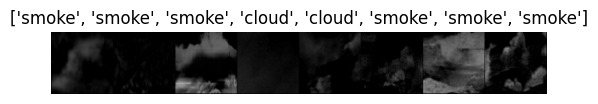

Prediction:


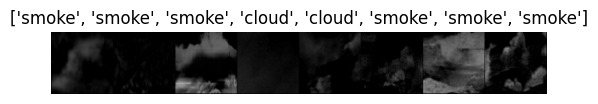

In [ ]:

visualize_model(resnet18, num_images=10)
torch.save(resnet34.state_dict(), 'difference/resnet34.pt')




In [ ]:
from google.colab import files
files.download('/content/othervssmoke/bestmodel.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
\

FileNotFoundError: ignored

In [ ]:
def confusion(vgg):
  from sklearn.metrics import confusion_matrix
  import seaborn as sn
  import pandas as pd


  y_pred = []
  y_true = []

  # iterate over test data
  for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        output = vgg(inputs)


        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

  # constant for classes
  classes = ('cloud', 'other','smoke')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [j for j in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.savefig('/content/output.png')

  # from sklearn.metrics import confusion_matrix
  # print("Confusion Matrix : ")
  # confusion_matrix(y_pred,y_true)

<ipython-input-27-849be911da3b>:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


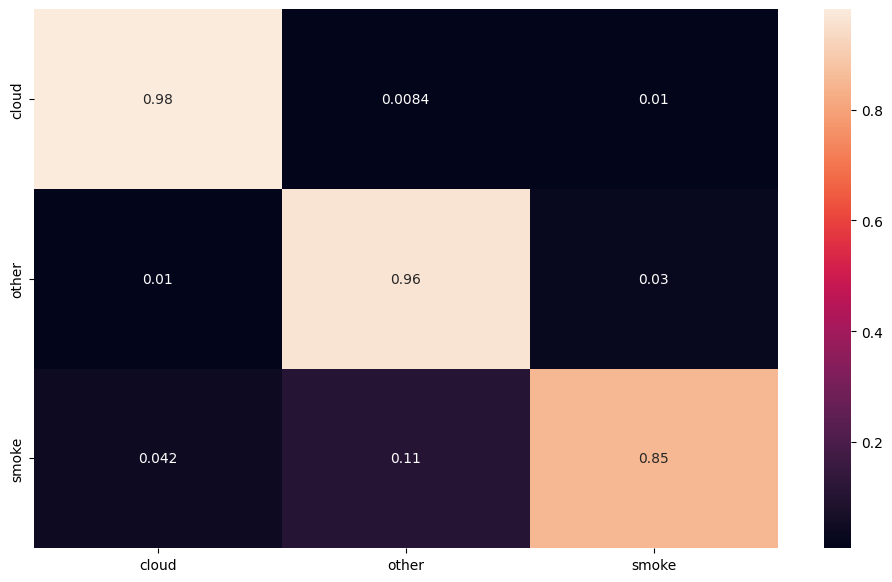

In [ ]:
confusion(resnet50)

In [ ]:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to('cuda')
        classes = classes.to('cuda')
        outputs = resnet50(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)